# Case Study: Interpolating Precipitation Data with Spatialize
On this document, the tools **`esi_hparams_search`** and **`esi_nongriddata`** will be employed to estimate daily precipitation over the Maipo Basin in Chile.

The ESI implementation for non-gridded data has enabled us to achieve interpolation on a 2.5D scenario (a curved surface), as opposed to the more common 2D (flat surface) and 3D (volume) scenarios.

## Setup

We'll start by loading the required libraries and inputs.

In [ ]:
# === Libraries ===

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Importar ESI desde repositorio, no desde instalación python, borrar antes de publicar!!
import sys
sys.path.append('../')
import import_helper
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

import numpy as np
import pandas as pd

# Spatialize:
from spatialize.gs.esi import esi_hparams_search, esi_nongriddata
import spatialize.gs.esi.lossfunction as lf

# Other interpolators:
from scipy.interpolate import griddata, RBFInterpolator
from sklearn.model_selection import GridSearchCV
from pykrige.rk import Krige

# Plots:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [17]:
# === Data ===
# Interpolation locations for the 'xi' input:
locs = pd.read_csv('../../data/PP_locations.csv', sep = ',')

# Precipitation data:
data = pd.read_csv('../../data/PP_samples.csv', sep = ",", header = 0)

# === Inputs ===
# Interpolation locations:
xi = locs[['X', 'Y', 'Z']].values

# Samples:
dates = list(data.columns)[3:6]      # List of studied dates (to iterate on)
points = {}
values = {}

for date in dates:
    mask = ~np.isnan(data[date])        # Mask for non-NaN values
    points[date] = data[['x', 'y', 'z']][mask].values
    values[date] = data[date][mask].values

# === To store results ===
results = locs.copy()
results.columns = pd.MultiIndex.from_tuples([(x, '') for x in results.columns])      #MultiIndex for results

Since we are working with a real, geolocated scenario, we'll create a plot format function and set some parameters to ease plotting.

In [ ]:
# Global configurations
sns.set_theme(context='notebook', style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
    'grid.alpha': 0.6,
    'axes.titleweight': 'demibold',
    'axes.titlesize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.titleweight': 'bold',
    'figure.titlesize': 13,
    'savefig.bbox': 'tight'
    })

# Global variables
locs_array = locs.set_index(['X', 'Y']).to_xarray()     # for imshow plots
study_area = gpd.read_file('../../data/PP_Basin/Basin_UTM.shp')        # study area shapefile
extent = [locs.X.min(), locs.X.max(), locs.Y.min(), locs.Y.max()]       # Plot extent

# Plot format function
def plot_format(ax):
    """ Sets plot limits, ticks, and plots study area """
    ax.set_xticks(ticks=[250000, 310000, 370000, 430000], labels=['250000', '310000', '370000', '430000'])
    ax.set_yticks(ticks=[6200000, 6240000, 6280000, 6320000, 6360000], labels=['6200000', '6240000', '6280000', '6320000', '6360000'])
    ax.set_xlim([250000 - 6000, 430000 + 6000])
    ax.set_ylim([6200000, 6360000])

    study_area.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Colormaps
data_cmap = sns.color_palette("blend:#ffe370,#84ffb8,#38b2ff,#009abe,#006a83,#004252", as_cmap=True)
data_cmap.set_under('#ffce06')
data_cmap.set_over('#00242d')

locs_cmap = sns.color_palette("blend:#80a74f,#bddb97,#e3cfb2,#d6b78c,#c9a066,#ba8842,#946c35,#825f2e,#332512", as_cmap=True)

error_cmap = sns.color_palette("blend:#4b7f52,#7dd181,#b6f9c9,#ffdf80,#f8a07f,#f57d4e,#d2430b", as_cmap=True)
error_cmap.set_over('#b93007')

## Visualizing the Input Data

### Precipitation Data

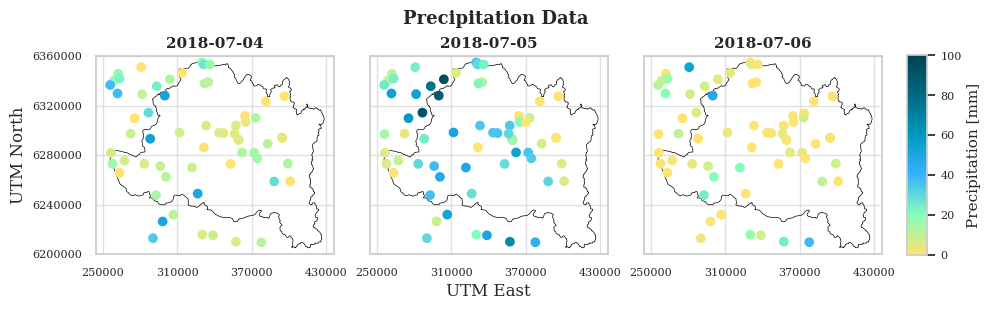

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9.8, 3), sharey=True, layout='compressed')

for i in range (0,3):
    date = dates[i]
    scatter = axs[i].scatter(data['x'], data['y'],
                             c=data[date], cmap=data_cmap,
                             clim=(0, 100), zorder=3)
    plot_format(axs[i])
    axs[i].set_title(date)

fig.suptitle('Precipitation Data')
axs[0].set_ylabel('UTM North')
axs[1].set_xlabel('UTM East')

cbar1 = plt.colorbar(scatter, ax=axs[2], aspect=10)
cbar1.set_label('Precipitation [mm]', fontsize=11)

plt.show()

### Interpolation Locations

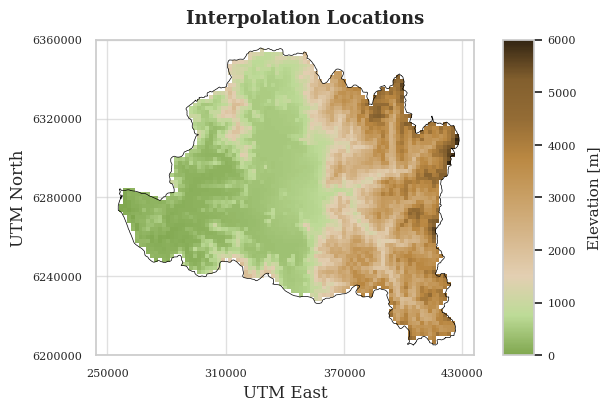

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='compressed')

image = ax.imshow(np.flipud(locs_array.Z.T), cmap=locs_cmap,
                  clim=(0, 6000), zorder=1, extent=extent)
plot_format(ax)

fig.suptitle('Interpolation Locations')
ax.set_ylabel('UTM North')
ax.set_xlabel('UTM East')

cbar = fig.colorbar(image, aspect=10)
cbar.set_label('Elevation [m]', labelpad=8, fontsize=11)

plt.show()

## Using ESI
In this section, we will implement the ESI algorithm to derive precipitation estimates across the whole surface of the Maipo Basin within three different dates.

**Modelling Setup**
- Inverse Distance Weighting (IDW) will be used as local interpolator. 
- The `esi_hparams_search` function will be used to identify optimal parameters for the `esi_nongriddata` function.
- Operational Error will be utilized for measuring uncertainty.

In [23]:
# To store parameters
parameters_idw = []

for date in dates:
    # Loss function: Operational error for the observed dynamic range
    op_error = lf.OperationalErrorLoss(np.abs(np.nanmin(values[date]) - np.nanmax(values[date])))

    # Searching for optimal parameters
    search_result = esi_hparams_search(points[date],
                                       values[date],
                                       xi,
                                       local_interpolator="idw",
                                       griddata=False,
                                       k=-1,
                                       n_partitions=[300],
                                       alpha=[0.7, 0.75, 0.8, 0.85, 0.9],
                                       exponent=np.round(np.arange(0.5, 3.1, 0.1), 1),
                                       seed=1500)
    
    best_params = search_result.best_result()

    # Using ESI
    result = esi_nongriddata(points=points[date],
                             values=values[date],
                             xi=xi,
                             n_partitions=300,
                             best_params_found=best_params,
                             seed=1500)

    # Store results
    results[(date, 'value')] = result._estimation
    results[(date, 'uncertainty')] = result.precision(op_error)
    
    # Store parameters (Optional):
    parameters_idw.append({'alpha': best_params['alpha'],
                           'exponent': best_params['exponent'],
                           'agg_func': best_params['agg_function']
                           })

parameters_idw = pd.DataFrame(parameters_idw, index=dates)

finished 100% of 130 iterations ... 

done (elapsed time: 19s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 130 iterations ... 

done (elapsed time: 17s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 130 iterations ... 

done (elapsed time: 21s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)


In [24]:
# View optimal parameters
parameters_idw

,alpha,exponent,agg_func
2018-07-04,0.70,3.00,<function mean at 0x11de4eef0>
2018-07-05,0.70,3.00,<function mean at 0x11de4eef0>
2018-07-06,0.70,3.00,<function mean at 0x11de4eef0>


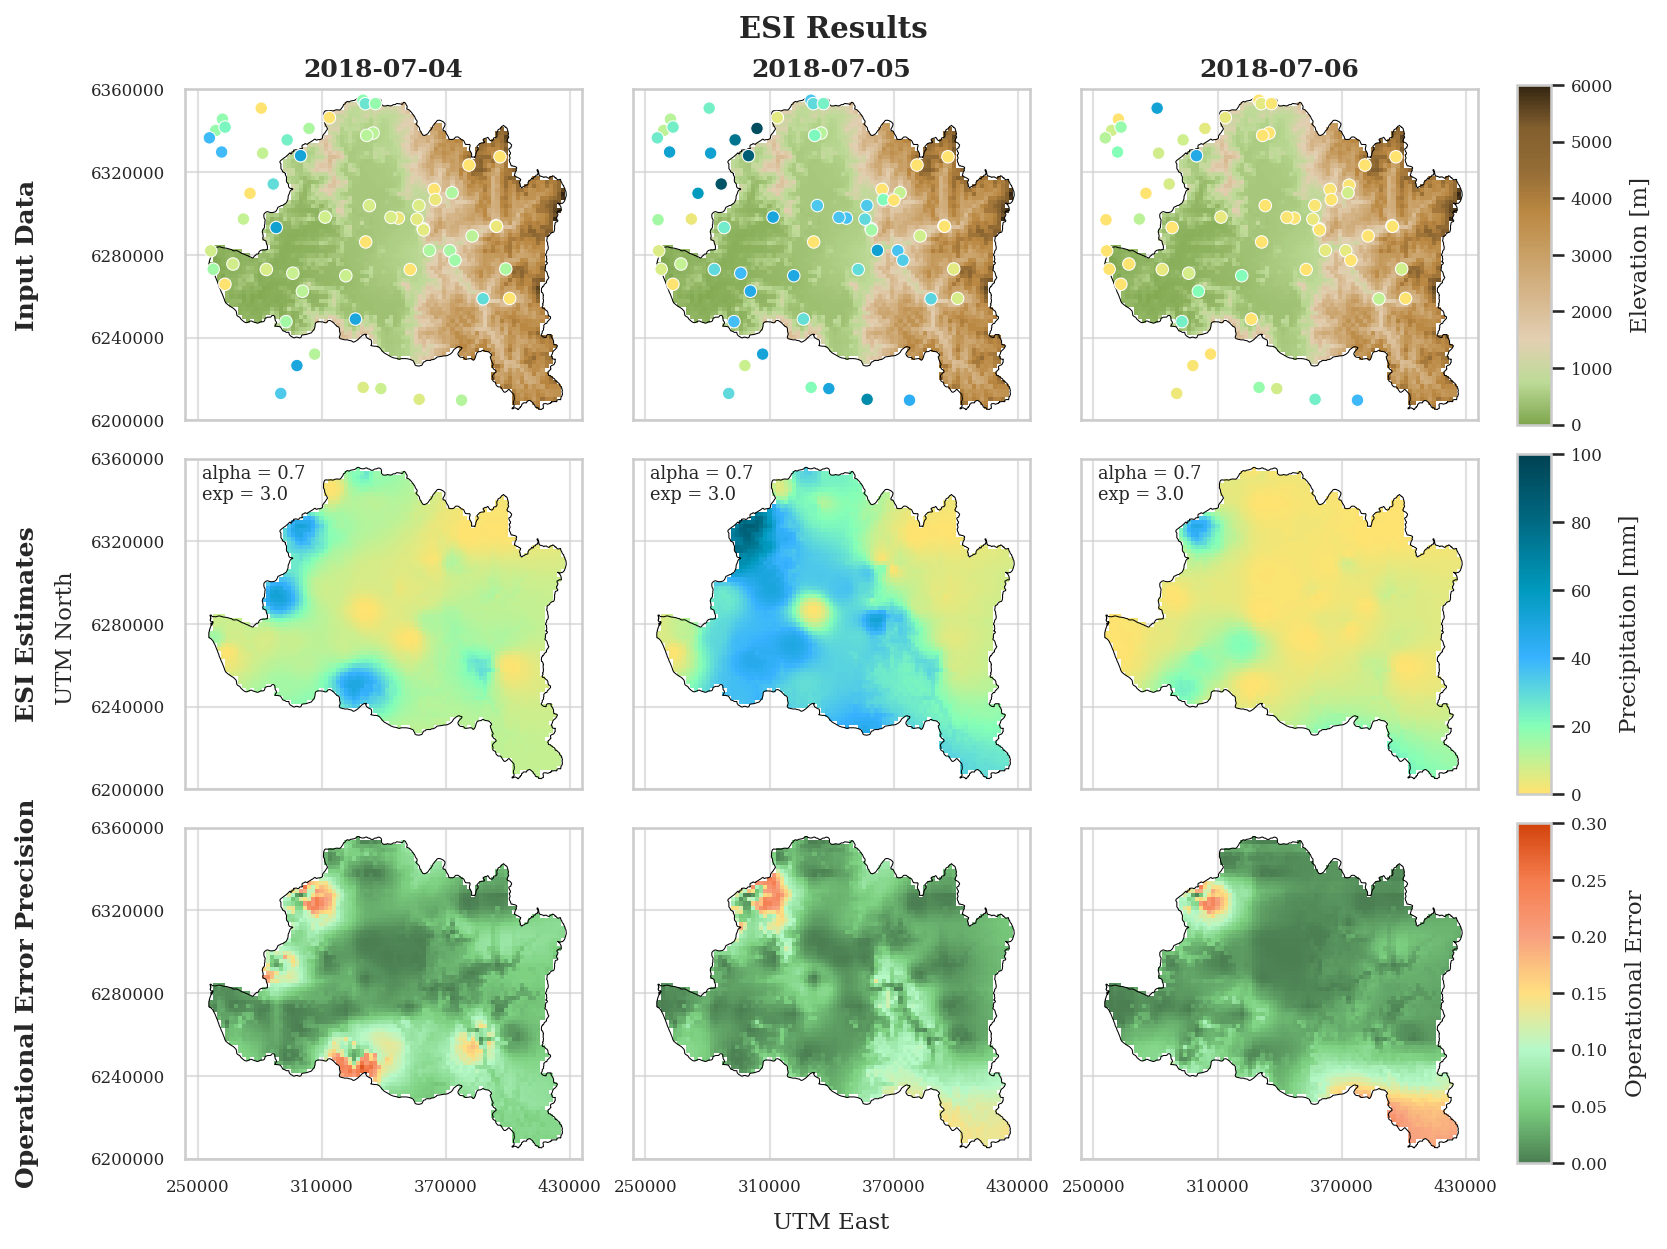

In [26]:
# === PLOTTING THE RESULTS ===

results_array = results.set_index(['X', 'Y']).to_xarray()

fig, axs = plt.subplots(3, 3, figsize = (11, 8.4), dpi = 150, sharex = True, sharey = True, layout = 'compressed')
fig.suptitle('ESI Results', fontsize = 14)

for j in range (0,3):
    date = dates[j]
    
    # Format
    axs[0,j].set_title(date, fontsize = 12)
    for i in range(0,3):
        plot_format(axs[i,j])
    
    # Input data and interpolation surface plot
    image = axs[0,j].imshow(np.flipud(locs_array.Z.T),
                            cmap = locs_cmap, clim = (0, 6000),
                            zorder = 1, extent = extent)
    scatter = axs[0,j].scatter(data['x'], data['y'],
                               c = data[date], cmap = data_cmap, clim = (0, 100),
                               edgecolors = 'white', linewidth = 0.5, zorder = 3)
    
    # ESI Result plot
    result_plot = axs[1,j].imshow(np.flipud(results_array[(date,'value')].T),
                                  cmap = data_cmap, clim = (0, 100), zorder = 1, extent = extent)
    axs[1,j].text(252000, 6340000,
                  f"alpha = {parameters_idw.loc[date, 'alpha']}\nexp = {parameters_idw.loc[date, 'exponent']}",
                  fontsize = 8.5)

    # Precision plot
    precision_plot = axs[2,j].imshow(np.flipud(results_array[(date,'uncertainty')].T),
                                 cmap = error_cmap, clim = (0, 0.3),
                                 zorder = 1, extent = extent)

# Titles and labels 
axs[0,0].set_ylabel('Input Data', labelpad = 25, fontweight = 'bold')
axs[1,0].set_ylabel('ESI Estimates', labelpad = 25, fontweight = 'bold')
axs[2,0].set_ylabel('Operational Error Precision', labelpad = 25, fontweight = 'bold')

axs[2,1].set_xlabel('UTM East', labelpad = 8, fontsize = 11)
fig.text(0.035, 0.5, 'UTM North', rotation = 'vertical', fontsize = 11, ha = 'center', va = 'center')

# Colorbars
cbar = plt.colorbar(image, ax = axs[0,2], aspect = 10)
cbar.set_label('Elevation [m]', labelpad = 8, fontsize = 11)

cbar1 = plt.colorbar(result_plot, ax = axs[1,2], aspect = 10)
cbar1.set_label('Precipitation [mm]', labelpad = 8, fontsize = 11)

cbar2 = plt.colorbar(precision_plot, ax = axs[2,2], aspect = 10)
cbar2.set_label('Operational Error', labelpad = 8, fontsize = 11)

plt.show()